In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import logsumexp

based on https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_15.ipynb

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

pandas    : 1.4.3
arviz     : 0.12.1
matplotlib: 3.5.2
scipy     : 1.8.1
numpy     : 1.22.4
pymc      : 4.1.3
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]

Watermark: 2.3.1



#### ch 15.1 measurement error

In [6]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

In [7]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [83]:
## standardize
d['D'] = stats.zscore(d['Divorce'])
d['D_sd'] = d['Divorce SE'] / d['Divorce'].std()
d['M'] = stats.zscore(d['Marriage'])
d['M_sd'] = d['Marriage SE'] / d['Marriage'].std()
d['A'] = stats.zscore(d['MedianAgeMarriage'])

In [15]:
with pm.Model() as m1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s", 1)
    A = pm.MutableData("A", d['A'])
    M = pm.MutableData("M", d['M'])
    D_sd = pm.MutableData("D_sd", d['D_sd'])
    mu = pm.Deterministic("mu", a + bA*A + bM*M)
    D_true = pm.Normal("D_true", mu, s)
    D_obs = pm.Normal("D_obs", D_true, D_sd, observed=d['D'])
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, s, D_true]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [19]:
az.summary(trace1, var_names=['a', 'bA', 'bM', 's'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.051,0.097,-0.236,0.132,0.002,0.001,3233.0,2963.0,1.00
bA,-0.608,0.161,-0.899,-0.290,0.003,0.002,2432.0,2860.0,1.00
bM,0.055,0.168,-0.256,0.361,0.004,0.002,2258.0,2810.0,1.00
s,0.601,0.104,0.419,0.799,0.003,0.002,1215.0,1577.0,1.01


In [81]:
with m1:
    ## set M to mean value
    pm.set_data({'M': np.zeros(len(d['M']))})
    postpred = pm.sample_posterior_predictive(trace1, var_names=['mu','D_true']).posterior_predictive

<AxesSubplot:>

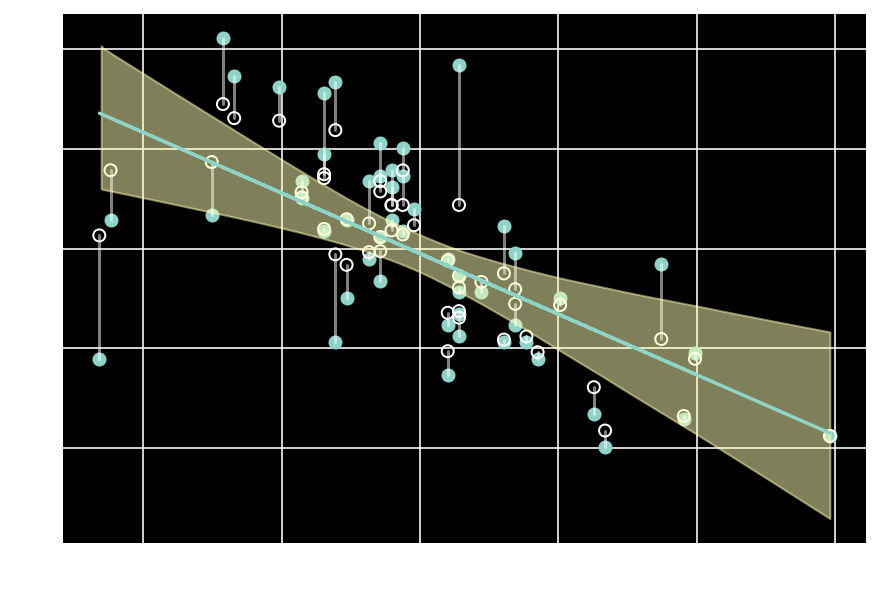

In [82]:
post = trace1.posterior
postmeans = post.mean(['chain','draw'])
_, ax = plt.subplots()
ax.scatter(d['A'], d['D'])
ax.scatter(d['A'], postmeans['D_true'], color="none", edgecolor="w")
## lines
ax.plot([d['A'],d['A']], [d['D'],postmeans['D_true']], "w-", alpha=0.5)
## mu is the linear model
ax.plot(d['A'], postpred['mu'].mean(['chain','draw']))
az.plot_hdi(d['A'], postpred['mu'])
#ax.plot(d['A'], postpred['D_true'].mean(['chain','draw']))
#az.plot_hdi(d['A'], postpred['D_true'])

## more shrinkage for states where Divorce_SE is higher

In [86]:
## incorporate measurement error in predictor M also
with pm.Model() as m2:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s", 1)
    A = pm.MutableData("A", d['A'])
    M = pm.MutableData("M", d['M'])
    D_sd = pm.MutableData("D_sd", d['D_sd'])
    M_sd = pm.MutableData("M_sd", d['M_sd'])
    ## true M has mean 0 and sd 1 (standardized)
    ##  (it would be better to use A -> M to model M_true)
    M_true = pm.Normal("M_true", 0, 1, shape=M.size)
    ## observed M comes from true M
    M_obs = pm.Normal("M_obs", M_true, M_sd, observed=M)
    ## mu depends on true M
    mu = pm.Deterministic("mu", a + bA*A + bM*M_true)
    D_true = pm.Normal("D_true", mu, s)
    D_obs = pm.Normal("D_obs", D_true, D_sd, observed=d['D'])
    trace2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, s, M_true, D_true]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [88]:
az.summary(trace2, var_names=['a', 'bA', 'bM', 's'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.039,0.099,-0.219,0.154,0.001,0.001,4853.0,3175.0,1.0
bA,-0.537,0.160,-0.860,-0.254,0.003,0.002,3135.0,2912.0,1.0
bM,0.199,0.205,-0.192,0.572,0.004,0.003,2309.0,2306.0,1.0
s,0.574,0.112,0.376,0.788,0.003,0.002,1260.0,1103.0,1.0


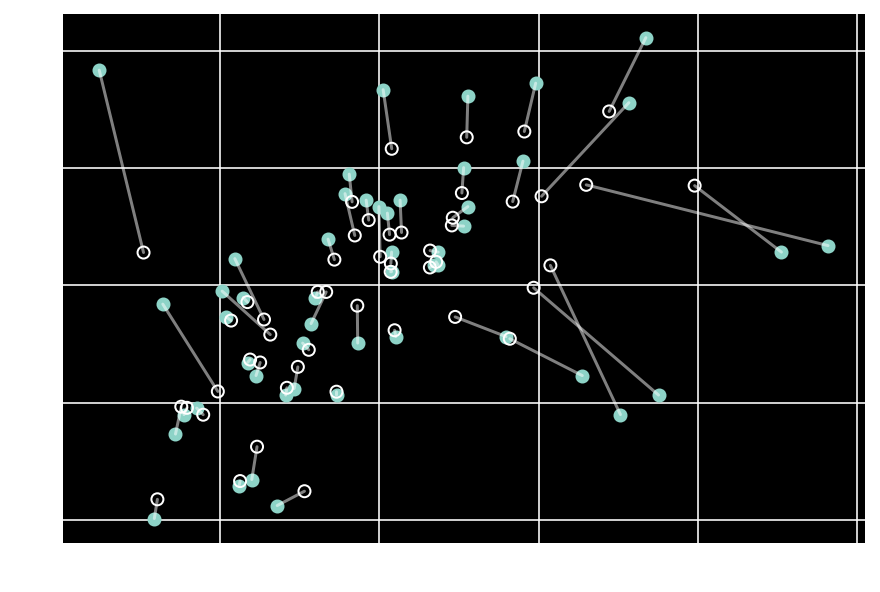

In [94]:
postmeans = trace2.posterior.mean(['chain','draw'])
_, ax = plt.subplots()
ax.scatter(d['M'],d['D'])
ax.scatter(postmeans['M_true'], postmeans['D_true'], color="none", edgecolor="w")
ax.plot([d['M'],postmeans['M_true']], [d['D'], postmeans['D_true']], "w-", alpha=0.5);

#### 15.2.2 imputing missing data

In [120]:
d = pd.read_csv("Data/milk.csv", sep=';')

In [121]:
d['B'] = stats.zscore(d['neocortex.perc'], nan_policy='omit')
d['K'] = stats.zscore(d['kcal.per.g'], nan_policy='omit')
d['logmass'] = np.log(d['mass'])
d['M'] = stats.zscore(d['logmass'], nan_policy='omit')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,B,K,logmass,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-2.144217,-0.956680,0.667829,-0.463904
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,NaN,-0.830572,0.737164,-0.422348
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,NaN,-1.145842,0.920283,-0.312595
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,NaN,-1.019734,0.482426,-0.575027
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,NaN,-0.263087,0.783902,-0.394336


In [127]:
with pm.Model() as m5:
    ## missing B values ~ Normal(muB, sB) ; need to estimate these params
    muB = pm.Normal("muB", 0, 0.5)
    sB = pm.Exponential("sB", 1)
    ## linear model
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    ## pymc doesn't know to impute data if you do this
    ## B = pm.MutableData("B", d['B'])
    M = pm.MutableData("M", d['M'])
    ## observed values are used to estimate muB and sB,
    ##  which are used to impute missing values
    Bi = pm.Normal("Bi", muB, sB, observed=d['B'])
    ## mu uses imputed values
    mu = pm.Deterministic("mu", a + bB*Bi + bM*M)
    ## likelihood
    s = pm.Exponential("s", 1)
    kcal = pm.Normal("kcal", mu, s, observed=d['K'])
    trace5 = pm.sample()


/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:1431: ImputationWarning: Data in Bi contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [muB, sB, a, bB, bM, Bi_missing, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [128]:
az.summary(trace5, var_names=['~mu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
muB,-0.046,0.216,-0.437,0.360,0.004,0.003,3729.0,3072.0,1.0
a,0.028,0.161,-0.280,0.321,0.002,0.003,4990.0,2993.0,1.0
bB,0.486,0.235,0.032,0.914,0.005,0.004,1832.0,2892.0,1.0
bM,-0.537,0.200,-0.922,-0.171,0.004,0.003,2609.0,3126.0,1.0
Bi_missing[0],-0.575,0.948,-2.365,1.249,0.015,0.012,3957.0,3026.0,1.0
Bi_missing[1],-0.714,0.983,-2.559,1.117,0.015,0.013,4246.0,3116.0,1.0
Bi_missing[2],-0.709,0.976,-2.552,1.155,0.016,0.013,3855.0,2933.0,1.0
Bi_missing[3],-0.299,0.907,-1.978,1.432,0.013,0.014,4680.0,3051.0,1.0
Bi_missing[4],0.482,0.940,-1.294,2.230,0.013,0.014,5256.0,2544.0,1.0
Bi_missing[5],-0.176,0.933,-1.929,1.628,0.013,0.015,5253.0,2464.0,1.0


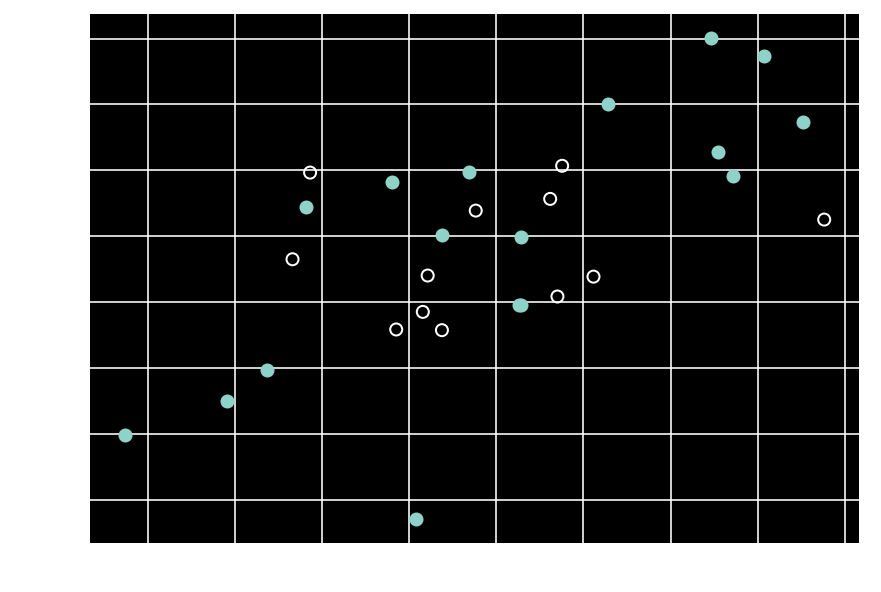

In [136]:
## above model does not know about M,B correlation caused by M <- U -> B
post = trace5.posterior
_, ax = plt.subplots()
ax.scatter(d['M'], d['B'])
ax.scatter(d['M'][d['neocortex.perc'].isna()], 
    post['Bi_missing'].mean(['chain','draw']), color="none", edgecolor="w");

In [150]:
## can improve it by modeling (M, B) ~ MVNormal
## but: "Automatic inputation is only supported for univariate RandomVariables"
with pm.Model() as m7:
    muB = pm.Normal("muB", 0, 0.5)
    muM = pm.Normal("muM", 0, 0.5)
    chol, _, _ = pm.LKJCholeskyCov("chol", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0))
    MB = pm.MvNormal("MB", mu=[muB,muM], chol=chol, observed=d[['M','B']])
    ## linear model
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    ## use imputed B and actual M
    mu = pm.Deterministic("mu", a + bB*MB[:,1] + bM*d['M'])
    ## likelihood
    s = pm.Exponential("s", 1)
    kcal = pm.Normal("kcal", mu, s, observed=d['K'])


/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:1431: ImputationWarning: Data in MB contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


NotImplementedError: Automatic inputation is only supported for univariate RandomVariables, but MB is multivariate

#### 15.3

$N \sim poisson(\lambda)$ ; N = notes sung  
$log(\lambda) = \alpha + \beta C$ ; C = presence/absence of cat  
$ C \sim bern(k) $ ; cat is present with prob k  
$ R_c \sim bern(r) $ ; cat data is missing with prob r

In [82]:
n = 100
a_true = 3.0# 5.0
b_true = -2.0 #-3.0
k_true = 0.5
r = 0.2
C = stats.bernoulli.rvs(p = k_true, size = n)
notes_obs = stats.poisson.rvs(mu = np.exp(a_true + b_true*C))
R_c = stats.bernoulli.rvs(p = r, size = n)
C_obs = C.copy()
C_obs[R_c == 1] = -9

In [70]:
with pm.Model() as m8:
    a = pm.Normal("a", 0, 5)
    b = pm.Normal("b", 0, 5)
    ## true k unknown, need to estimate
    k = pm.Beta("k", 2, 2)

    ## manually add the log-likelihood for cat unknown cases using pm.Potential()
    ## p = p(cat)p(notes|cat) + p(no cat)p(notes|no cat)
    logp_N_cat = pm.logp(pm.Poisson.dist(pm.math.exp(a+b)) , notes_obs[C_obs == -9])
    logp_N_nocat = pm.logp(pm.Poisson.dist(pm.math.exp(a)) , notes_obs[C_obs == -9])
    logpCpNcat = pm.math.log(k) + logp_N_cat
    logpCpNno = pm.math.log(1-k) + logp_N_nocat
    total_logp = pm.math.logsumexp( pm.math.stack([logpCpNcat,logpCpNno]) , axis=0)
    notes_RC1 = pm.Potential("notes|RC==1", total_logp)

    ## true k unknown, need to estimate
    cat_RC0 = pm.Bernoulli("cat|RC==0", k, observed=C_obs[C_obs != -9])
    ## likelihood when cat data available
    mu = pm.Deterministic("mu", pm.math.exp(a + b*cat_RC0))
    notes_RC0 = pm.Poisson("notes|RC==0", mu, observed=notes_obs[C_obs != -9])

    trace8 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [61]:
## logsumexp
p1 = np.array([0.1,0.2,0.3])
p2 = np.array([0.4,0.5,0.6])
p12 = p1 + p2
logp1 = np.log(p1)
logp2 = np.log(p2)
logp12 = np.log(p12)

print(logp12)
print(logsumexp(np.stack([logp1,logp2]),axis=0))

[-0.69314718 -0.35667494 -0.10536052]
[-0.69314718 -0.35667494 -0.10536052]


In [71]:
az.summary(trace8)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.020,0.033,2.955,3.077,0.000,0.000,5051.0,3324.0,1.0
b,-2.007,0.088,-2.177,-1.845,0.001,0.001,4527.0,3015.0,1.0
k,0.510,0.049,0.420,0.607,0.001,0.000,5431.0,2802.0,1.0
mu[0],2.765,0.226,2.366,3.202,0.003,0.002,4797.0,3406.0,1.0
mu[1],2.765,0.226,2.366,3.202,0.003,0.002,4797.0,3406.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[76],2.765,0.226,2.366,3.202,0.003,0.002,4797.0,3406.0,1.0
mu[77],2.765,0.226,2.366,3.202,0.003,0.002,4797.0,3406.0,1.0
mu[78],2.765,0.226,2.366,3.202,0.003,0.002,4797.0,3406.0,1.0
mu[79],2.765,0.226,2.366,3.202,0.003,0.002,4797.0,3406.0,1.0


In [84]:
## reconstruct posterior prob for unknown cats
with pm.Model() as m9:
    a = pm.Normal("a", 0, 5)
    b = pm.Normal("b", 0, 5)
    k = pm.Beta("k", 2, 2)

    logp_N_cat = pm.logp(pm.Poisson.dist(pm.math.exp(a+b)) , notes_obs[C_obs == -9])
    logp_N_nocat = pm.logp(pm.Poisson.dist(pm.math.exp(a)) , notes_obs[C_obs == -9])
    logpCpNcat = pm.math.log(k) + logp_N_cat
    logpCpNno = pm.math.log(1-k) + logp_N_nocat
    total_logp = pm.math.logsumexp( pm.math.stack([logpCpNcat,logpCpNno]) , axis=0)
    notes_RC1 = pm.Potential("notes|RC==1", total_logp)

    cat_RC0 = pm.Bernoulli("cat|RC==0", k, observed=C_obs[C_obs != -9])
    mu = pm.Deterministic("mu", pm.math.exp(a + b*cat_RC0))
    notes_RC0 = pm.Poisson("notes|RC==0", mu, observed=notes_obs[C_obs != -9])

    ## p(c=1|N) = p(N|c=1)p(c=1) / p(N)
    ##    p(N) = p(n|c=1)p(c=1) + p(n|c=0)p(c=0)
    logpC1 = pm.math.log(k) + pm.logp(pm.Poisson.dist(pm.math.exp(a+b)) , notes_obs)
    logpC0 = pm.math.log(1-k) + pm.logp(pm.Poisson.dist(pm.math.exp(a)) , notes_obs)
    pC1 = pm.Deterministic("pC1", pm.math.exp(logpC1) / (pm.math.exp(logpC1) + pm.math.exp(logpC0)) )
    trace9 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [85]:
az.summary(trace9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.939,0.035,2.873,3.004,0.001,0.000,3676.0,3190.0,1.0
b,-1.904,0.087,-2.071,-1.746,0.001,0.001,3911.0,3427.0,1.0
k,0.576,0.048,0.494,0.670,0.001,0.000,5746.0,3196.0,1.0
mu[0],2.822,0.219,2.435,3.246,0.003,0.002,4706.0,3559.0,1.0
mu[1],2.822,0.219,2.435,3.246,0.003,0.002,4706.0,3559.0,1.0
...,...,...,...,...,...,...,...,...,...
pC1[95],1.000,0.000,1.000,1.000,0.000,0.000,3540.0,2581.0,1.0
pC1[96],0.000,0.000,0.000,0.000,0.000,0.000,4454.0,3473.0,1.0
pC1[97],1.000,0.000,1.000,1.000,0.000,0.000,3356.0,2673.0,1.0
pC1[98],0.000,0.000,0.000,0.000,0.000,0.000,4928.0,3527.0,1.0


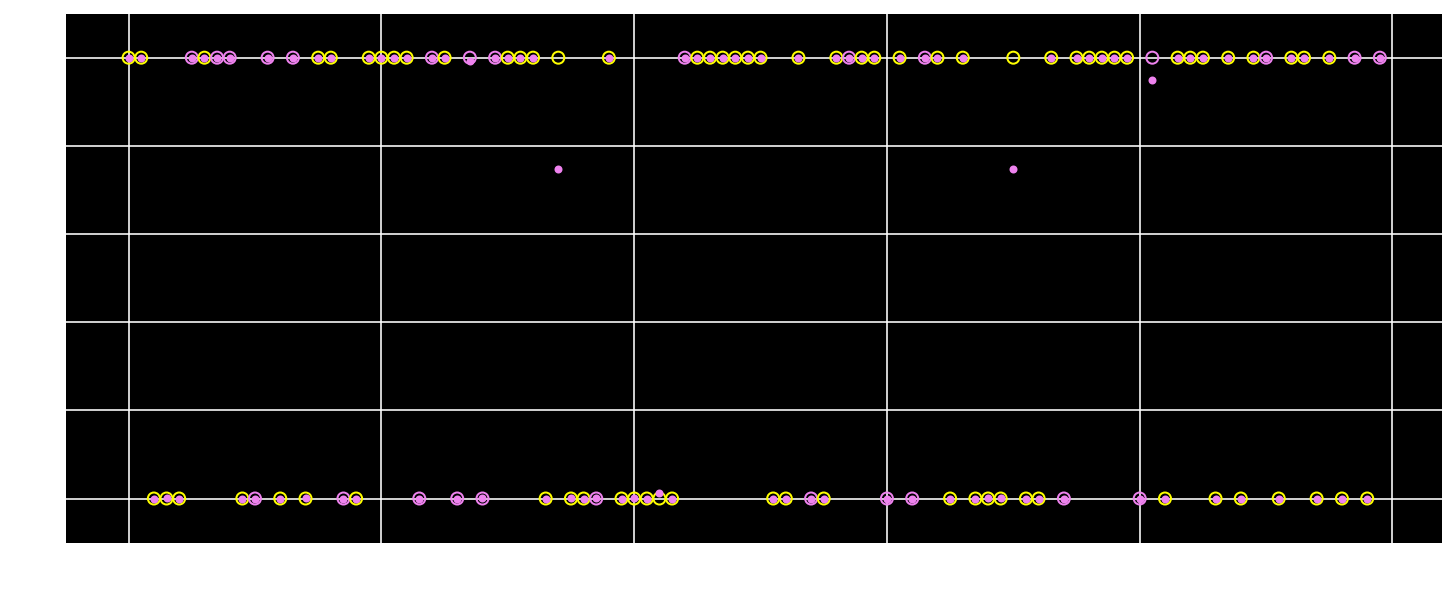

In [108]:
_, ax = plt.subplots(figsize=[10,4])
ax.set_ylim(-0.1,1.1)
ax.scatter(np.arange(n), C, color="none", edgecolor=["violet" if x==-9 else "yellow" for x in C_obs])
ax.scatter(np.arange(n) , trace9.posterior['pC1'].mean(['chain','draw']), marker='.', color="violet")